#Presentation 2
### Why are customers leaving their credit card services and going else where.

## $\color{red}{\text{Import Required Packages}}$

In [35]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pylab as plt

## $\color{red}{\text{Importing Data}}$

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
%cd '/content/drive/MyDrive/DS 4510/Data'
churn_df = pd.read_excel('churn.xlsx', sheet_name = "BankChurners")

/content/drive/MyDrive/DS 4510/Data


## $\color{red}{\text{Data Transformation}}$

### $\color{blue}{\text{Missing Value Analysis}}$

- Checking missing values in the data

In [38]:
# Function to compute missing values
def percent_missing(data):
    return data.isnull().sum().divide(len(data)).sort_values(ascending=False)

# Using the function
percent_missing(churn_df).head()

Total_Revolving_Bal    0.243902
Education_Level        0.149995
Income_Category        0.109805
Marital_Status         0.073961
Credit_Limit           0.003456
dtype: float64

### $\color{blue}{\text{Imputation}}$

In [39]:
# Function to do conditional deletion

def semi_listwise(data, nan_percent):
    d1 = data.isnull().sum().divide(len(data)).sort_values(ascending=False)
    culprit_vars = []
    for i in range(len(d1.values)):
        if(d1.values[i] >= nan_percent):
            culprit_vars.append(d1.index[i])
    return data[data.columns.difference(culprit_vars)]

In [40]:
# Deleting any row with missing data (25%)
delCol25_num = semi_listwise(churn_df, 0.25)

# Check if deletion worked
print(churn_df.shape) # Printing shape of original data
print(delCol25_num.shape) # Printing shape of deleted columns

(10127, 21)
(10127, 21)


In [41]:
# Find the median
col_med = delCol25_num.median() # calculating the median for each column
# print(col_med) # Printing the medians for each column

# Now inpute missing data with the median
no_missing = delCol25_num.fillna(col_med) # Filling in missing data with the median for each column

# Now check if data is missing
percent_missing(no_missing)

<ipython-input-41-9691cf0a6fc8>:2: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  col_med = delCol25_num.median() # calculating the median for each column


Education_Level          0.149995
Income_Category          0.109805
Marital_Status           0.073961
Client_ID                0.000000
Contacts_In12Mon         0.000000
Total_Ct_Chng_Q4_Q1      0.000000
Total_Trans_Ct           0.000000
Total_Trans_Amt          0.000000
Total_Amt_Chng_Q4_Q1     0.000000
Avg_Open_To_Buy          0.000000
Total_Revolving_Bal      0.000000
Credit_Limit             0.000000
Products_By_Clients      0.000000
Inactive_In12Mon         0.000000
Client_Attrition         0.000000
Months_With_Bank         0.000000
Card_Category            0.000000
Dependent_Count          0.000000
Gender                   0.000000
Age                      0.000000
Avg_Utilization_Ratio    0.000000
dtype: float64

### $\color{blue}{\text{Multicollinearity}}$

**Multicollinearity** occurs when variables have similar information
- Variables with a correlation greater than 0.70 are considered to have similar information

In [43]:
# !pip install dython
from dython.nominal import associations
import seaborn as sns

def corrPlot(data):

  # Use "associations" function to compute correlation between all variables
  corr_matrix = associations(dataset=data, compute_only=True)['corr']

  # Mask the upper triangle of correlation heatmap
  mask_upper = np.triu(np.ones_like(corr_matrix, dtype=bool))

  # Plotting correlation heatmap
  plt.figure(figsize=(12, 8))
  sns.heatmap(corr_matrix, annot=True, mask=mask_upper, cmap='coolwarm_r', fmt='.2f', vmin=-1, vmax=1)
  plt.show()

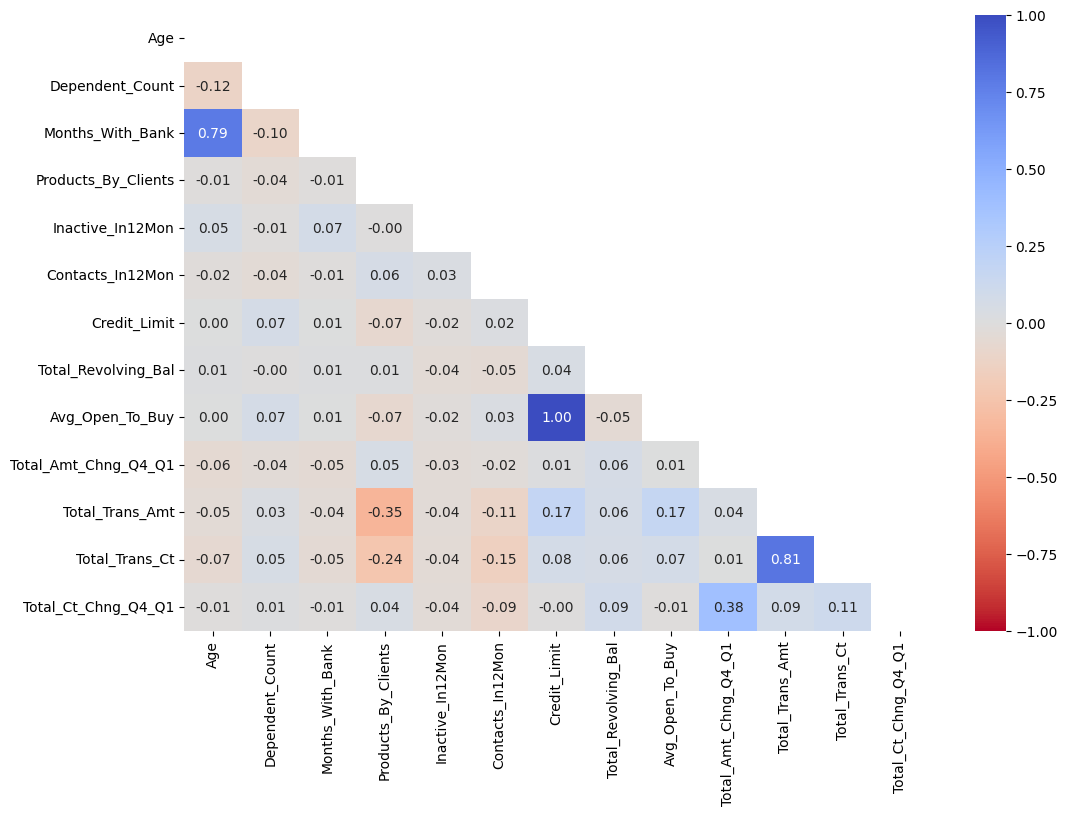

In [44]:
# Drop the following variables from the data, as they are not needed for the analysis
drop_vars = ["Avg_Utilization_Ratio", "Education_Level", "Client_ID", "Client_Attrition", "Gender", "Marital_Status", "Card_Category", "Income_Category"]
new_churn = churn_df.drop(drop_vars, axis=1)

# Use function to plot correlation heatmap
corrPlot(new_churn)

### $\color{blue}{\text{Removing Colinear Variables}}$
- If correlation between variables are greater than 0.7 (70%), one of the variables should be removed.

In [45]:
'''
This function drops highly correlated variables given a threshold.
It drops the variable with smaller variance
'''

def drop_highly_correlated(data, threshold):
    cor_matrix = data.corr().abs()
    sol = (cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))).unstack().dropna()

    to_drop=[]
    for i in range(len(sol[sol > threshold].index.tolist())):
        var1 = sol[sol >= threshold].index.tolist()[i][0]
        var2 = sol[sol >= threshold].index.tolist()[i][1]

        if(data[var1].var() < data[var2].var()): to_drop.append(var1)
        else: to_drop.append(var2)

    dropped_vars = list(set(to_drop))
    return dropped_vars, data.drop(dropped_vars, axis=1)

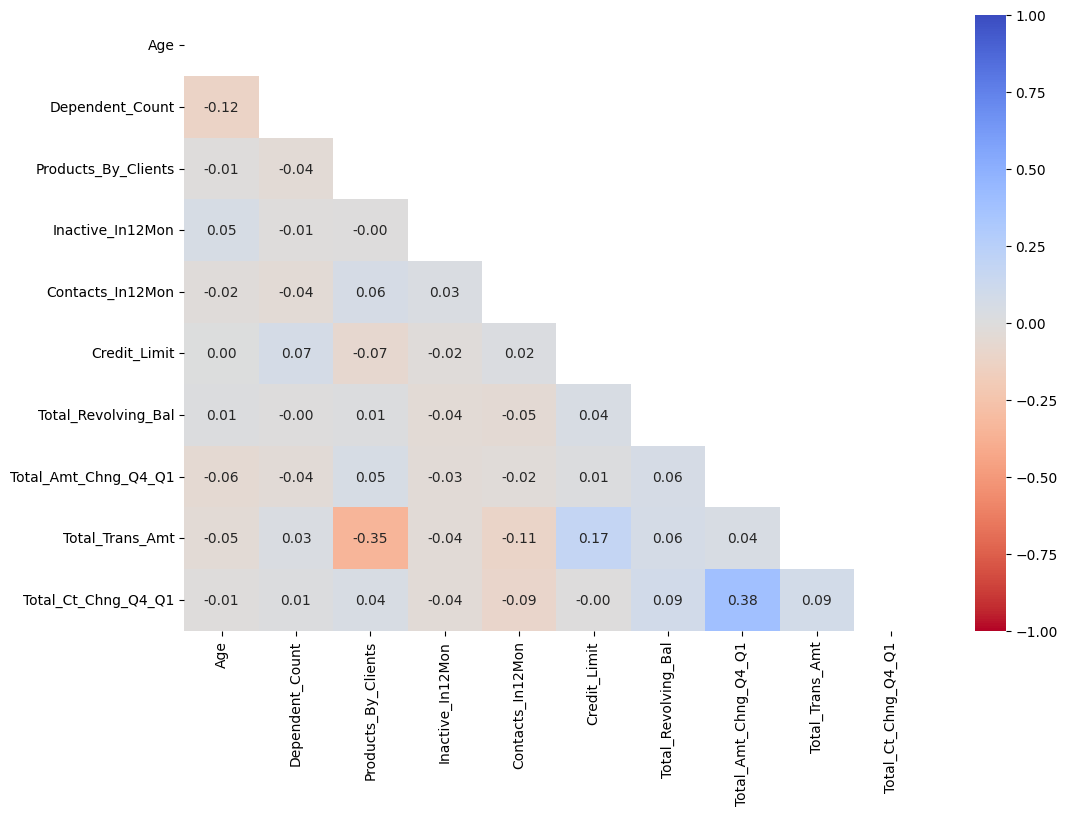

In [46]:
# Drop the following variables from the data, as they are not needed for the analysis
drop_vars = ["Avg_Utilization_Ratio", "Education_Level", "Client_ID", "Client_Attrition", "Gender", "Marital_Status", "Card_Category", "Income_Category"]
new_churn = churn_df.drop(drop_vars, axis=1)

# Use the function to remove variables with high correlation
dropped_vars, new_churn_v2 = drop_highly_correlated(data=new_churn, threshold=0.7)

# Plot the correlation of the resulting data
corrPlot(data = new_churn_v2)

### $\color{blue}{\text{Removing Near Zero-Variance Variables}}$
- Some variables have little or no variation. They do not add much value to the model

In [47]:
from sklearn.feature_selection import VarianceThreshold

vThreshold = VarianceThreshold(threshold = 0.1)
vThreshold.fit_transform(new_churn_v2)

# Get variables with greater variance
vars = new_churn_v2.columns[vThreshold.get_support()]

# Subset data for variables with greater variance
churn_varDf = new_churn_v2[vars]

### $\color{blue}{\text{Standardization}}$

- To reduce the effect of outliers

In [48]:
from sklearn.preprocessing import StandardScaler

# Standardize data // comparing variables 'apples to apples'
churn_std = StandardScaler().fit_transform(churn_varDf)
# Transforms housing_std into a data frame and getting column names instead of numbers
churn_stdDf = pd.DataFrame(churn_std, columns = churn_varDf.columns)

# Bring the dependent variable to the standardized data // do NOT standardize dependent variable
churn_std_full = pd.concat([churn_stdDf, churn_df['Avg_Utilization_Ratio']], axis = 1)

### $\color{blue}{\text{Data Partitioning}}$

1. Identify dependent and independent variables
2. Partition the data such that 70% is used for training and 30% is used for testing

In [49]:
from sklearn.model_selection import train_test_split

# Independent variables used for regression
depVar = churn_std_full['Avg_Utilization_Ratio']
indVar = churn_std_full.drop('Avg_Utilization_Ratio', axis = 1)

# Partition data into training(70%) and testing(30%).
trainX, testX, trainY, testY = train_test_split(indVar, depVar, test_size = 0.3, random_state = 1)

## $\color{red}{\text{Linear Regression}}$

### $\color{blue}{\text{Multiple Linear Regression Model Training and Output}}$

In [53]:
import statsmodels.api as sm

# Add the intercept term into the TRAINing data
trainX = sm.add_constant(trainX)

# Model with the training data
mlr_model = sm.OLS(trainX[Avg_Utilization_Ratio], trainX.drop(axis = 1)).fit()

# Print model summary
print(mlr_model.summary())

NameError: name 'Avg_Utilization_Ratio' is not defined

### $\color{blue}{\text{Simple Linear Regression Model Prediction and Output}}$

### $\color{blue}{\text{Residual Analysis and QQ Plot for SLR}}$

- Residual Analysis and QQ-Plot

### $\color{blue}{\text{Residual Analysis and QQ Plot for MLR}}$

- Residual Analysis and QQ-Plot

## $\color{red}{\text{Quantile Regression}}$

### $\color{blue}{\text{Quantile Regression Model and Output}}$

### $\color{blue}{\text{Multiple Linear Regression Model and Output}}$

### $\color{blue}{\text{Model Prediction}}$

- Predict the **Avg_Utilization_Ratio** of the testing data as a function of the independent variables

#### $\color{green}{\text{Quantile Regression}}$

#### $\color{green}{\text{Multiple Linear Regression}}$

## $\color{red}{\text{Lasso Regression}}$


## $\color{red}{\text{Decision Tree and Random Forest Regression}}$

### $\color{blue}{\text{Model Fitting and Result}}$
